In [2]:
# imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

# Data Preprocessing

In [3]:
df = pd.read_csv('covid-data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [4]:
# create a mapping that indicates the boolean values of the columns
bools = {1:True, 2:False}

# iterate through all of the boolean columsn in the dataset
for name in df.drop(['AGE', 'DATE_DIED', 'MEDICAL_UNIT', 'CLASIFFICATION_FINAL'], axis=1).columns:

    # remap integer values to bools
    df[name] = df[name].map(bools)

    # display
    print(name, df[name].unique())

USMER [False  True]
SEX [ True False]
PATIENT_TYPE [ True False]
INTUBED [nan True False]
PNEUMONIA [True False nan]
PREGNANT [False nan True]
DIABETES [False True nan]
COPD [False True nan]
ASTHMA [False True nan]
INMSUPR [False True nan]
HIPERTENSION [True False nan]
OTHER_DISEASE [False True nan]
CARDIOVASCULAR [False True nan]
OBESITY [False True nan]
RENAL_CHRONIC [False True nan]
TOBACCO [False True nan]
ICU [nan False True]


In [5]:
# after doing our remapping we can see that there are actually a lot of missing values in this datasets
df.isna().sum()

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                          0
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64

We need to find a target variable that represents how at risk an individual truly was. To do this, I have chosen to utilize outcomes that we know result in higher resource expenditure. These 4 factors are hospilitization, being put in the ICU, being placed on a ventilator, and dying. All four outcomes need more medical resources than a typical COVID patient.

In [6]:
# create a new column that indicates whether the patient died
df['DIED'] = df['DATE_DIED'].apply(lambda x: False if x == '9999-99-99' else True)

# Replace NA values with False. While this is not technically accurate, it will aid in roughly approximating the risk function.
# We want to make use of the all of the data that we have without assuming any negative events that do not ahve evidence.
df['INTUBED'] = df['INTUBED'].fillna(False)
df['ICU'] = df['ICU'].fillna(False)

# We are classifying someone has being high risk if they died or were put in intensive care or were placed on a ventilator or were hosptilaized. 
# this choice helps establish risk as a measure of additional hospital resources needed (which is the reason why we want this approximation)
df['HIGH_RISK'] = np.logical_or(np.logical_or(np.logical_or(df['DIED'], df['ICU']), df['INTUBED']), np.logical_not(df['PATIENT_TYPE']))

In [7]:
# renaming the sex column to more accurately reflect its meaning
df = df.rename(columns={'SEX':'IS_WOMAN'})

In [8]:
# Let's ensure that all male values of pregancy are indicated as False instead of null. Why we do recognize that intersex people do exist and this adds complicatiosn
# we cannot expect our model to have that level of nuance, and medical professionals working with those populations would be aware that typical models may not work.

df['PREGNANT'] = np.where(df['IS_WOMAN'] == True, df['PREGNANT'], False)

In [9]:
# drop some unnecessary columns
df = df.drop(['ICU', 'DIED', 'INTUBED', 'DATE_DIED', 'PATIENT_TYPE'], axis=1)

In [10]:
# now we have reduced the total number of NA values to be small, so we will drop them from our dataset
df = df.dropna()

In [11]:
# correct data types of columns that need it
for name in ['USMER', 'IS_WOMAN',
       'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO']:
    df[name] = df[name].astype('bool')

In [12]:
# Now we will split the data into train and test sets

X = df.drop('HIGH_RISK', axis=1)
y = df['HIGH_RISK']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=10)

# Data Exploration

In [13]:
# for the purposes of graphing and data exploration we will be creating a combined set of the training values
combined_train = X_train.copy()
combined_train['HIGH_RISK'] = y_train

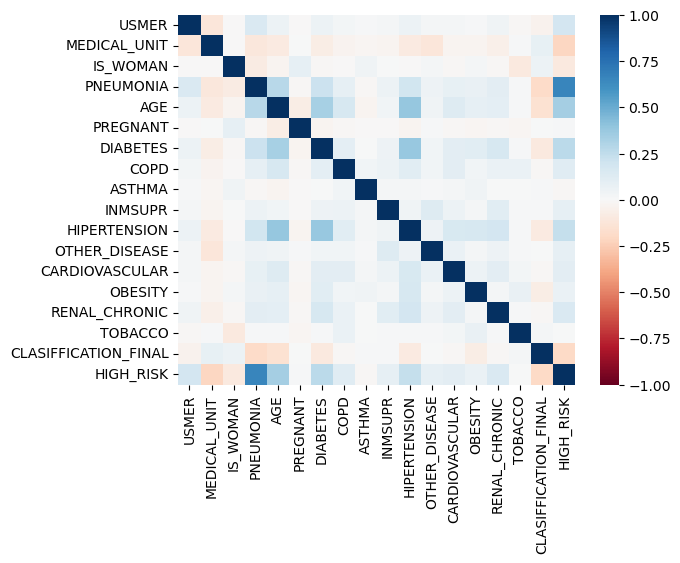

In [14]:
# create a heatmap to better understand the correlation among variables
sns.heatmap(combined_train.corr(), vmin=-1, vmax=1, cmap='RdBu')

plt.show()

In [15]:
combined_train.corr().iloc[:,-1].sort_values()

MEDICAL_UNIT           -0.216637
CLASIFFICATION_FINAL   -0.202752
IS_WOMAN               -0.094111
ASTHMA                 -0.014436
TOBACCO                 0.005089
PREGNANT                0.008273
OBESITY                 0.067754
OTHER_DISEASE           0.091407
INMSUPR                 0.092438
CARDIOVASCULAR          0.104908
COPD                    0.119410
RENAL_CHRONIC           0.152655
USMER                   0.184638
HIPERTENSION            0.241254
DIABETES                0.265967
AGE                     0.337456
PNEUMONIA               0.662771
HIGH_RISK               1.000000
Name: HIGH_RISK, dtype: float64

We can see from the above colormap that there is some degree of multicolinearity among the data, and we can see that Pneuomnia, Age, Diabetes, Hypertension, Chronic Renal Disease, USMER, COVID symptom severity, and Medical Unit have the strongest linear association with the risk category.

We will choose to not include Hypertension in our model because it has a reasonably high degree of colinearity with Age and Diabetes (as would be expected), and logistic regressiosn are not meant to handle multicolinearity

# Model and Evaluation

In [16]:
# Updating our variable selections
X_train = X_train[['PNEUMONIA', 'AGE', 'DIABETES', 'USMER', 'RENAL_CHRONIC', 'CLASIFFICATION_FINAL', 'MEDICAL_UNIT']]
X_test = X_test[['PNEUMONIA', 'AGE', 'DIABETES', 'USMER', 'RENAL_CHRONIC', 'CLASIFFICATION_FINAL', 'MEDICAL_UNIT']]

In [17]:
# Train and fit Logistic Regression
lm = LogisticRegression()
lm.fit(X_train, y_train)

# create test predictions
y_pred = lm.predict(X_test)

# Give scoring metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.97      0.94    247310
        True       0.85      0.62      0.71     59284

    accuracy                           0.90    306594
   macro avg       0.88      0.80      0.83    306594
weighted avg       0.90      0.90      0.90    306594



Based on this classification report we can see that our model has good performance at detecting when people are at low risk, but our model performs much worse on evaluating high risk individuals. This makes sense given that true positives are a minority class and have had less data to train on.
An important metric to highlight is the recall. Only 62% of true-positives were actually identified. This is especially bad in a healthcare scenario like this one because the consequences for not having enough resources are much higher than having too many.

One way to address issues of class imbalance is undersampling. We artificially rebalance our training data so that there are less occurences of low risk individuals and our model won't weight them as highly

In [18]:
us = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = us.fit_resample(X_train, y_train)

# Train and fit Logistic Regression
lm = LogisticRegression()
lm.fit(X_resampled, y_resampled)

# create test predictions
y_pred = lm.predict(X_test)

# Give scoring metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.91      0.93    247310
        True       0.68      0.78      0.72     59284

    accuracy                           0.88    306594
   macro avg       0.81      0.84      0.82    306594
weighted avg       0.89      0.88      0.89    306594



After implementing undersampling we can see that the total accuracy and f1 only decreased marginally, but the recall is now 16 points higher! This is a huge difference. This change did make the precision worse (so we will incorrectly identify low risk individuals as high risk more often), but this is a good trade off in our scenario. Overestimating someone's risk is not ideal, but it is not nearly as bad as underestimating because underestimating can leave patients without the critical resoures that they need.

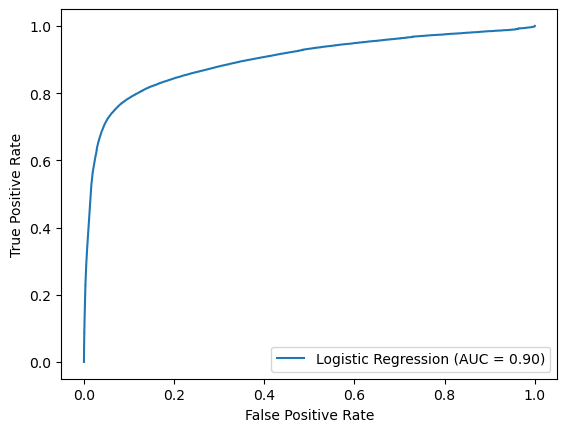

In [19]:
# create predicted probabilityes for the test set
y_scores = lm.predict_proba(X_test)[::,1]

# calculate important values for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Find the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Show the graph for the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')

display.plot()

Finally we can use an ROC curve to understand the performance of our model. The sharp spike up in the beginning indicates that we very quickly reach a high rate of true positives with minimal false positives (which is exactly what we want). And if we are willing to make more false positives we can achieve marginally better true positive performance.